In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from dsb2018 import Dsb2018Dataset


%matplotlib inline

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Root directory of the project
ROOT_DIR = os.getcwd()

/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "dsb2018_logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Size of train data:603
Size of val data:67


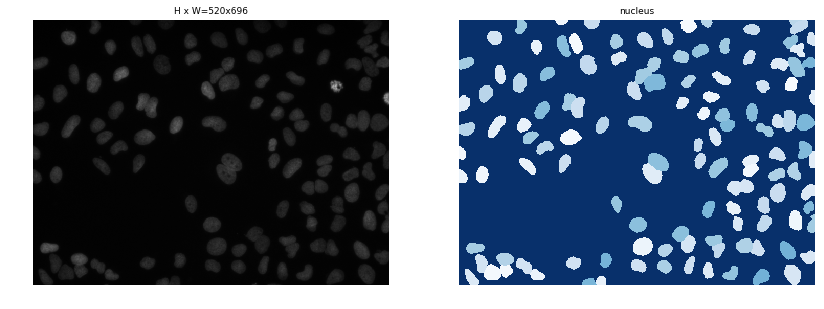

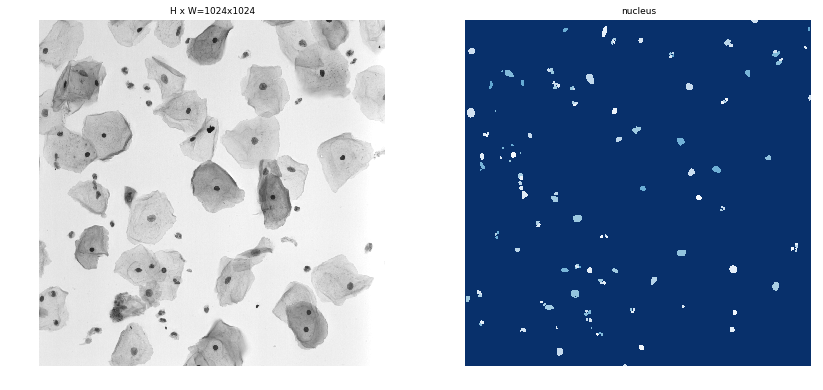

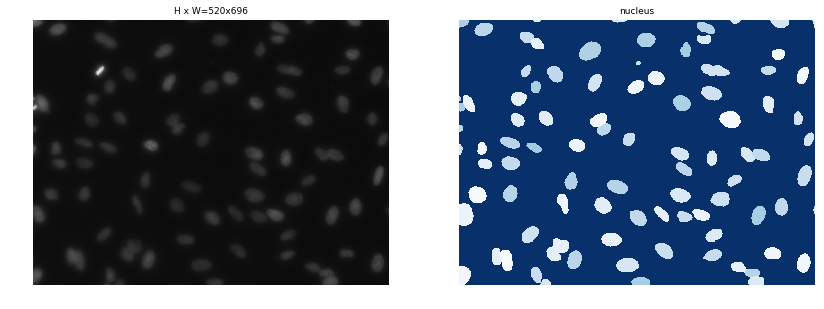

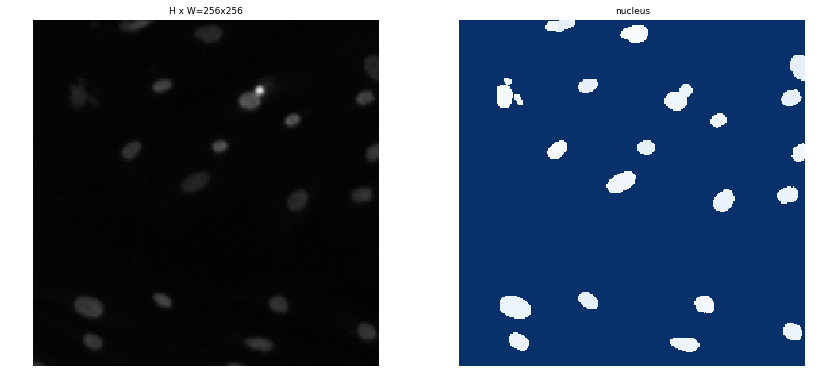

In [3]:
# Training dataset
train_data = Dsb2018Dataset()
train_data.load_dsb2018('../DSB2018')
train_data.prepare()

val_data = Dsb2018Dataset()
val_data.load_dsb2018('../DSB2018', is_trainset=False)
val_data.prepare()
print("Size of train data:{}".format(len(train_data.image_ids)))
print("Size of val data:{}".format(len(val_data.image_ids)))


#Load and display random samples
image_ids = np.random.choice(train_data.image_ids, 2)
for image_id in image_ids:
    image = train_data.load_image(image_id)
    mask, class_ids = train_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_data.class_names, limit=1)
    
    
#Load and display random samples
image_ids = np.random.choice(val_data.image_ids, 2)
for image_id in image_ids:
    image = val_data.load_image(image_id)
    mask, class_ids = val_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, val_data.class_names, limit=1)


In [4]:
class Dsb2018Config(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "DSB2018"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    USE_MINI_MASK = True
    
    #MINI_MASK_SHAPE = (112, 112)  # (height, width) of the mini-mask


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64,128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200
    
    DETECTION_MAX_INSTANCES = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 152

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 18
    
    DETECTION_MIN_CONFIDENCE = 0.7
    
config = Dsb2018Config()

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
print("model ready!")


model ready!


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_data, val_data,
            learning_rate=config.LEARNING_RATE,
            epochs=400,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180223T2307/mask_rcnn_dsb2018_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/400
152/152 [==============================] - 530s 3s/step - loss: 2.0665 - rpn_class_loss: 0.2603 - rpn_bbox_loss: 0.8674 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.4784 - val_loss: 1.4105 - val_rpn_class_loss: 0.1668 - val_rpn_bbox_loss: 0.6612 - val_mrcnn_class_loss: 0.1444 - val_mrcnn_bbox_loss: 0.2020 - val_mrcnn_mask_loss: 0.2361
Epoch 2/400
152/152 [==============================] - 535s 4s/step - loss: 1.4567 - rpn_class_loss: 0.1254 - rpn_bbox_loss: 0.6967 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.2688 - val_loss: 1.3973 - val_rpn_class_loss: 0.1245 - val_rpn_bbox_loss: 0.5891 - val_mrcnn_class_loss: 0.1959 - val_mrcnn_bbox_loss: 0.2303 - val_mrcnn_mask_loss: 0.2575
Epoch 3/400
152/152 [==============================] - 501s 3s/step - loss: 1.3008 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.6238 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.2494 - val_loss: 1.2834 - val_rpn_clas

Process Process-2:
Traceback (most recent call last):
  File "/home/keven/miniconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/keven/miniconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/utils/data_utils.py", line 655, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/home/keven/miniconda3/envs/tensorflow/lib/python3.6/multiprocessing/managers.py", line 756, in _callmethod
    conn.send((self._id, methodname, args, kwds))
  File "/home/keven/miniconda3/envs/tensorflow/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/home/keven/miniconda3/envs/tensorflow/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    s

KeyboardInterrupt: 

In [5]:
import scipy.misc
        
import json
from skimage.io import imread, imshow, imread_collection, concatenate_images
import matplotlib.pyplot as plt
from utils import resize_image, resize_mask

class InferenceConfig(Dsb2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
model_path = '/home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180223T2307/mask_rcnn_dsb2018_0087.h5'
print(model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

def unpad(img, pad):
    y,x = img.shape
    top = pad[0][0]
    bottom = pad[0][1]
    left = pad[1][0]
    right = pad[1][1]
    
    startx = left
    endx = x-right
    starty = top
    endy = y-bottom
        
    return img[starty:endy,startx:endx]

def unpad3d(img, pad):
    y,x, _ = img.shape
    top = pad[0][0]
    bottom = pad[0][1]
    left = pad[1][0]
    right = pad[1][1]
    
    startx = left
    endx = x-right
    starty = top
    endy = y-bottom
        
    return img[starty:endy,startx:endx, :]


def revert_size(image, origin_size):
    result = scipy.misc.imresize(
            image,(origin_size[0],origin_size[1]))
    return result
    
def revert_size3d(image, origin_size):
    return scipy.misc.imresize(
            image, (origin_size[0], origin_size[1]))

def revert_resizing_3d(img, origin_size, padding):
    unpadding = unpad3d(img, padding)
    return revert_size3d(unpadding, origin_size)

def revert_resizing(img, origin_size, padding):
    unpadding = unpad(img, padding)
    try:
        return revert_size(unpadding, origin_size)
    except ValueError:
        print("error img, shape:{}, unpadding shape:{}, scale:{}, padding:{}"
              .format(img.shape, unpadding.shape, scale, padding))

def load_testset(pathname):
    dictionaries = []
    with open(pathname) as data:
        dictionaries = json.load(data)
    return dictionaries

base_dir = '../DSB2018'

test_set = load_testset(os.path.join(base_dir, 'test.json'))
print("prediction model loaded")

/home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180223T2307/mask_rcnn_dsb2018_0087.h5
Loading weights from  /home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180223T2307/mask_rcnn_dsb2018_0087.h5
prediction model loaded


In [22]:
from tqdm import tqdm

import cv2

test_path = '../data/stage1_test/'
def load_original_test_data(test_path):
    result = []
    test_ids = next(os.walk(test_path))[1]
    print("Prepare test images ...")
    sys.stdout.flush()
    for i, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = test_path + id_
        img = cv2.imread(path + '/images/' + id_ + '.png')
        # sizes_test records original diamension (width and heigh) of each test image.
        result.append([id_+'.png', img])
    return result
        
test_data = load_original_test_data(test_path)
print("loaded {} test images".format(len(test_data)))

assert(len(test_set) == len(test_data))
for i, iter in tqdm(enumerate(test_data), total=len(test_data)):
    found = False
    for j in range(len(test_set)):
        if test_set[j]['image']['pathname'] == iter[0]:
            img2 = imread(os.path.join(base_dir, 'images', test_set[j]['image']['pathname']))
            assert(img2.shape == iter[1].shape)      
            found = True
    assert(found == True)
print("all match")

Prepare test images ...


 34%|███▍      | 22/65 [00:00<00:00, 201.17it/s]

loaded 65 test images


100%|██████████| 65/65 [00:00<00:00, 185.57it/s]

all match


In [ ]:
# Test on a random train image
image_id = random.choice(train_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(train_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_data.class_names, figsize=(8, 8))

# mask, class_ids = train_data.load_mask(image_id)
# visualize.display_top_masks(original_image, mask, class_ids, train_data.class_names, limit=1)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())

In [ ]:
# Test on a random validation image
image_id = random.choice(val_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

print("img size:{}".format(original_image.shape))
print("mask size:{}".format(gt_mask.shape))

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            val_data.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_data.class_names, r['scores'], ax=get_ax())



In [ ]:
# Test on a random test image

i = random.randint(0, len(test_set)-1)
print(i)
test = test_set[10]
print(test)
test_img = imread(os.path.join(base_dir, 'images', test['image']['pathname']))
print("original shape:{}".format(test_img.shape))
test_img,_, scale,padding = resize_image(test_img, min_dim=512,max_dim=512, padding=True)
print("resized shape:{}, scale:{}, padding:{}".format(test_img.shape,scale, padding))
plt.figure(figsize=(6,6))
imshow(test_img)
plt.show()

results = model.detect([test_img], verbose=1)
r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())
first_mask = r['masks'][:,:,0]
first_mask = np.expand_dims(first_mask, axis=2)
print('mask shape:{}'.format(first_mask.shape))
print(resize_mask(first_mask, scale, padding).shape)

In [6]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(val_data.image_ids, 65)
APs = []
for image_id in val_data.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP:  0.8000914802672354


In [ ]:
i = 0
# testing revert_resizing
img_data = test_set[i]
origin_img = imread(os.path.join(base_dir, 'images', img_data['image']['pathname']))
origin_size = origin_img.shape
print("origin_size:{}".format(origin_size))
resized_img,_, scale,padding = resize_image(origin_img, min_dim=512,max_dim=512, padding=True)

results = model.detect([resized_img], verbose=1)
masks = results[0]['masks']


revert_img = revert_resizing_3d(resized_img, origin_size, padding)

assert(revert_img.shape == origin_img.shape)

print(masks.shape)
imshow(revert_img)
plt.show()

imshow(origin_img)
plt.show()
print(masks[:,:,0].shape)


for i in range(masks.shape[-1]):
    mask = masks[:,:, i]
    reverted = revert_resizing(mask, origin_size, padding)
        
        
# for i in range(masks.shape[-1]):
#     print(masks[:,:,i].shape)
#     print(revert_resizing(masks[:,:,i], scale, padding).shape)
#     imshow(np.squeeze(masks[:,:,i]))
#     plt.show()

In [ ]:
# debug image
i = 2
# testing revert_resizing
img_data = test_set[i]
origin_img = imread(os.path.join(base_dir, 'images', img_data['image']['pathname']))
origin_size = origin_img.shape
print("origin_size:{}".format(origin_size))
resized_img,_, scale,padding = resize_image(origin_img, min_dim=512,max_dim=512, padding=True)

results = model.detect([resized_img], verbose=1)
masks = results[0]['masks']
r = results[0]
visualize.display_instances(resized_img, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())



revert_img = revert_resizing_3d(resized_img, origin_size, padding)

assert(revert_img.shape == origin_img.shape)

reverted_masks = []
for i in range(masks.shape[-1]):
    mask = masks[:,:, i]
    reverted = revert_resizing(mask, origin_size, padding)
    reverted_masks.append(reverted)


# inter = reverted_masks[2]*reverted_masks[5]
# print(np.nonzero(inter))



print(len(reverted_masks))
plt.figure(figsize=(7,7))
imshow(np.squeeze(reverted_masks[8]))
plt.show()
plt.figure(figsize=(7,7))
imshow(np.squeeze(reverted_masks[10]))
plt.show()

inter = reverted_masks[8]*reverted_masks[10]
print(np.nonzero(inter))
row, col = np.nonzero(inter)
if len(row)>0:
    reverted_masks[8][row, col] = 0
# for i in range(len(reverted_masks)):
#     for j in range(i+1,len(reverted_masks)):
#         print("i:{}, j:{}".format(i,j))
#         inter = reverted_masks[i]*reverted_masks[j]
#         assert(len(np.nonzero(inter)[0]) == 0)


In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
import warnings
warnings.filterwarnings('ignore')


# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# convert single mask shape (h,w) into a list, 1: foreground, 0: background
def rle_encoding(x):
#     total = x.T.flatten().shape[0]
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

def run_length_encode(mask, index_offset = 1):

    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated.
    If index_offset = 1 we assume arrays start at 1.
    '''

    inds = np.append(np.insert(mask.flatten(), 0, 0), 0) 
    runs = np.where(inds[1:] != inds[:-1])[0]
    runs[1::2] = runs[1::2] - runs[:-1:2] 

    if index_offset > 0:
        runs[0::2] += index_offset

    rle = ' '.join([str(r) for r in runs])

    return rle

def single_image(test):
    lines = []
    image_id =  test['image']['pathname']
    origin_img = imread(os.path.join(base_dir, 'images', test['image']['pathname']))
#     print("origin image shape:{}".format(origin_img.shape))
    resized_img,_, scale,padding = resize_image(origin_img, min_dim=512,max_dim=512, padding=True)
#     print("handing img:{}, scale:{}, padding:{}".format(image_id, scale, padding))


    results = model.detect([resized_img], verbose=0)
    scores = results[0]['scores']
    masks = results[0]['masks']
#     visualize.display_instances(resized_img, r['rois'], r['masks'], r['class_ids'], 
#                             train_data.class_names, r['scores'], ax=get_ax())
    s0 = 1
    for s in scores:
        if s< s0:
            s0 = s
#     print("{} masks detected, lowest score is {}".format(masks.shape[-1], s0))
    
#     print("origin image shape:{}".format(origin_img.shape))


    reverted_masks = []
    for i in range(masks.shape[-1]):
        mask = masks[:,:,i]
        reverted_mask = revert_resizing(mask, origin_img.shape, padding)
        assert(reverted_mask.shape[0] == origin_img.shape[0])
        assert(reverted_mask.shape[1] == origin_img.shape[1])
        reverted_masks.append(reverted_mask)
    
    for i in range(len(reverted_masks)):
        for j in range(i+1, len(reverted_masks)):
            interaction = reverted_masks[i]*reverted_masks[j]
            row, col = np.nonzero(interaction)
            if len(row)>0:
#                 print("before, {} pixels overlapping between mask {} and {}".format(len(row), i, j))
                reverted_masks[i][row, col] = 0
#                 print("after, {} pixels overlapping".format(len(np.nonzero(reverted_masks[i]*reverted_masks[j])[0])))
                
    
    for i in range(len(reverted_masks)):
        assert(reverted_masks[i].shape[0] == origin_img.shape[0])
        assert(reverted_masks[i].shape[1] == origin_img.shape[1])
        rle = rle_encoding(reverted_masks[i])
        lines.append("{},{}".format(image_id[:-4],rle))
    return lines

base_dir = '../DSB2018'
test_set = load_testset(os.path.join(base_dir, 'test.json'))
sum = 0

def double_check(line):
    image_id = line.split(",")[0]
    pixels = line.split(",")[1]
    last_pixel = -100
    try:
        last_pixel = int(pixels.split(" ")[-2])+int(pixels.split(" ")[-1])-1
    except ValueError:
        print("Error line:{}".format(line))
    except IndexError:
        print("Error line:{}".format(line))
#     print("image:{}.png, last pixel:{}".format(image_id, last_pixel))
    img = imread(os.path.join(base_dir, 'images',image_id+'.png' ))
    if img.shape[0]*img.shape[1]<= last_pixel:
        print("image {}, total: {}, rle:{}".format(image_id,img.shape[0]*img.shape[1], last_pixel ))
#     assert(img.shape[0]*img.shape[1]>=last_pixel)
with open('sub_baseline-arg.csv', 'w') as f: 
    f.write('ImageId,EncodedPixels\n')
    for i, test in enumerate(test_set):
        lines = single_image(test)
        if i == 0: print(lines[0])
        for line in lines:
            if line.endswith(','):
                print("no pixel in mask:{}".format(line))
                continue
            double_check(line)
            sum+=1
            f.write(line)
            f.write('\n')
    
print("submision file completed, in total {} masks!".format(sum))

519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0,42371 6 42625 14 42880 17 43135 20 43391 21 43647 22 43903 22 44159 23 44416 22 44672 21 44929 20 45186 18 45443 15 45701 10
image fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3, total: 65536, rle:65536
image 697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808, total: 65536, rle:65536
image 191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829, total: 65536, rle:65536
image fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f, total: 65536, rle:65536
submision file completed, in total 3058 masks!


In [14]:
print(len(test_set))

65


In [12]:
import numpy as np
a = np.array([[1,1,0], [0,0,0], [1,0,0]])
b = np.array([[0,0,0], [0,0,0], [0,0,0]])
print(a*b)
len(np.nonzero(a*b)[0]) == 0

[[0 0 0]
 [0 0 0]
 [0 0 0]]


True

In [ ]:
def rle_encoding(x):
#     total = x.T.flatten().shape[0]
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

def run_length_encode(mask, index_offset = 0):

    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated.
    If index_offset = 1 we assume arrays start at 1.
    '''

    inds = np.append(np.insert(mask.flatten(), 0, 0), 0) 
    runs = np.where(inds[1:] != inds[:-1])[0]
    runs[1::2] = runs[1::2] - runs[:-1:2] 

    if index_offset > 0:
        runs[0::2] += index_offset

    rle = ' '.join([str(r) for r in runs])

    return rle

a = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,0,1,1,1], [0,0,0,1,1]])
print(a)
print(run_length_encode(a.T, 1))
print(rle_encoding(a))